# Notebook description

NEF users specify functions to decode in each connection. A common oversight is to not account for the dynamics of the synapse within the connections. The synapse is equivalent to a low-pass filter and will thus delay and attenuate the signal depending on the speed of the signal and the synaptic time constant. If this is the intention of the user, then all is well. If, as is often the case, the user is assuming that the function will be computed instantaneously, then this is a problem.

This notebook looks at how a user can use the NEF dynamical system formulation to change the speed of a computation. While, of course, it is impossible to compute instantaneously, we will see that it is possible to speed up the system by orders of magnitude.

# Setting the speed of a system

Linear dynamical systems are specified with 

$$\dot{x}=Ax+Bu$$

or in the complex frequency domain with

$$sX(s) = AX(s)+BU(s)$$

$A$ governs the stability and speed of the system. For stability (only considering 1D for now...), $A<0$. To make a stable system faster, make $|A|$ bigger.

The steady state value is

$$x=-A^{-1}Bu$$

so to make the system settle at $u$, set 

$$B=-A$$

NEF specifies [how](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/theory/NEF_dynamics.ipynb) to map dynamical systems on to recurrent neural networks. 
To control the speed of an NEF network, we formulate the network as the dynamical system

\begin{align}
\tau_{sys}\dot{x} &= -x + u \\
\dot{x} &= -\frac{1}{\tau_{sys}}x+\frac{1}{\tau_{sys}}u \\
\end{align}

That is, we want the system to respond to its input with speed $1/\tau_{sys}$, which is independent of the synaptic time constant $\tau_{syn}$.

For this system

\begin{align}
A &= -\frac{1}{\tau_{sys}} \\
B &= \frac{1}{\tau_{sys}} \\
\end{align}

so

\begin{align}
A' &= -\frac{\tau_{syn}}{\tau_{sys}} + I \\
B' &= \frac{\tau_{syn}}{\tau_{sys}} \\
\end{align}

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import nengo
from nengo.utils.functions import piecewise

In [3]:
def run_neural_dyn_sys(nneurons, dim, pstc, A, B, in_fun, T):
    Ap = pstc*A+np.identity(dim)
    Bp = pstc*B

    net = nengo.Network()
    with net:
        node_in = nengo.Node(in_fun)
        ens = nengo.Ensemble(nneurons, dim)
        nengo.Connection(ens, ens, transform=Ap, synapse=pstc)
        nengo.Connection(node_in, ens, transform=Bp, synapse=pstc)
        probe_in = nengo.Probe(node_in)
        probe_ens = nengo.Probe(ens)
    sim = nengo.Simulator(net)
    sim.run(T, progress_bar=False)
    return sim.trange(), sim.data[probe_in], sim.data[probe_ens]

def run_comm_channel(nneurons, dim, pstc, in_fun, T):
    net = nengo.Network()
    with net:
        node_in = nengo.Node(in_fun)
        ens = nengo.Ensemble(nneurons, dim)
        nengo.Connection(node_in, ens, synapse=pstc)
        probe_in = nengo.Probe(node_in)
        probe_ens = nengo.Probe(ens)
    sim = nengo.Simulator(net)
    sim.run(T, progress_bar=False)
    return sim.trange(), sim.data[probe_in], sim.data[probe_ens]


def run_dyn_sys(tau, u, dt, x0=0):
    decay = np.exp(-dt/tau)
    increment = 1.-decay
    N = u.shape[0]
    x = np.zeros(N)
    x[0] = x0
    for i in xrange(1, N):
        x[i] = decay*x[i-1]+increment*u[i]
    return x


def sample_fun(in_fun, dt, T):
    N = int(T/dt)
    u = np.zeros(N)
    t = dt*np.arange(N)
    for idx in xrange(N):
        u[idx] = in_fun(t[idx])
    return u


def pct_rmse(x_target, x):
    err = x_target-x
    rmse = np.linalg.norm(err)
    rms = np.linalg.norm(x_target)
    return rmse/rms

In [4]:
# parameters common across simulations
nneurons = 100
dim = 1
pstc = 0.1
T = 6
dt = .001
in_fun = piecewise({0: 0, 1: 1, 2: -1, 4: 0, 5: 1})

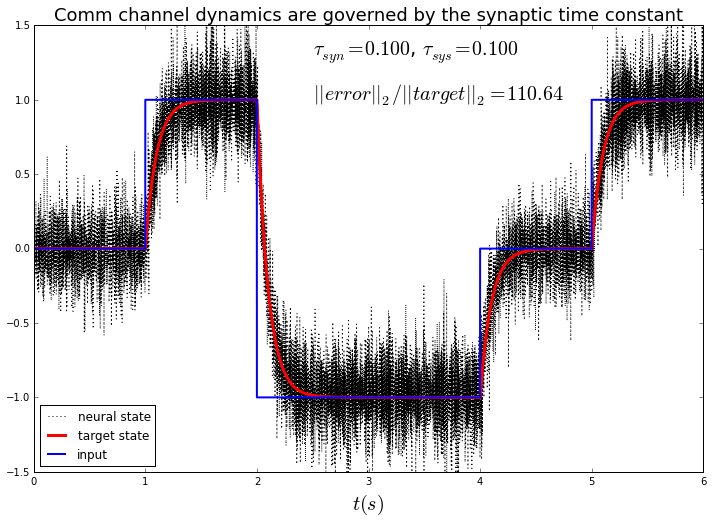

In [5]:
# run a comm channel
tau_sys = pstc

t, in_dat, ens_dat = run_comm_channel(nneurons, dim, pstc, in_fun, T)
x = run_dyn_sys(tau_sys, sample_fun(in_fun, dt, T), dt)
figure(figsize=(12,8))
subplot(111)
plot(t, ens_dat, 'k:', label="neural state")
plot(t, x, 'r', lw=3, label="target state")
plot(t, in_dat, 'b', lw=2, label="input")
ylim(-1.5, 1.5)
xlabel(r'$t(s)$', fontsize=20)
legend(loc='lower left')
text(2.5, 1.3, r'$\tau_{syn}=%.3f$, $\tau_{sys}=%.3f$' % (pstc, tau_sys), fontsize=20)
text(2.5, 1, r'$||error||_2/||target||_2=%.2f$' % pct_rmse(x, ens_dat), fontsize=20)
title('Comm channel dynamics are governed by the synaptic time constant', fontsize=18);

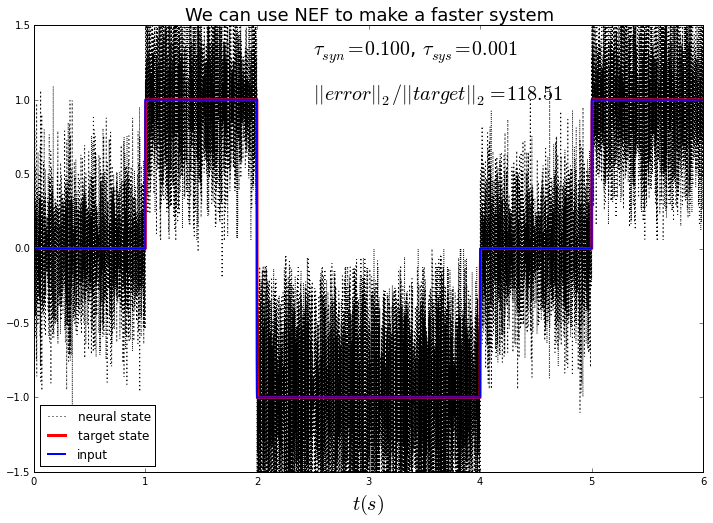

In [6]:
# run a lowpass filter that's faster than the synapse
tau_sys = pstc/100.
A = -1./tau_sys
B = -A

t, in_dat, ens_dat = run_neural_dyn_sys(nneurons, dim, pstc, A, B, in_fun, T)
x = run_dyn_sys(tau_sys, sample_fun(in_fun, dt, T), dt)
figure(figsize=(12,8))
subplot(111)
plot(t, ens_dat, 'k:', label="neural state")
plot(t, x, 'r', lw=3, label="target state")
plot(t, in_dat, 'b', lw=2, label="input")
ylim(-1.5, 1.5)
xlabel(r'$t(s)$', fontsize=20)
legend(loc='lower left')
text(2.5, 1.3, r'$\tau_{syn}=%.3f$, $\tau_{sys}=%.3f$' % (pstc, tau_sys), fontsize=20)
text(2.5, 1, r'$||error||_2/||target||_2=%.2f$' % pct_rmse(x, ens_dat), fontsize=20)
title('We can use NEF to make a faster system', fontsize=18);

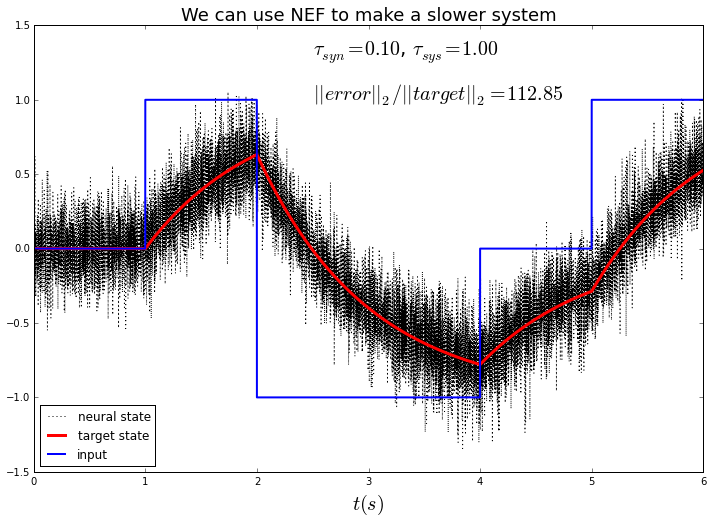

In [7]:
# run a lowpass filter that's faster than the synapse
tau_sys = pstc*10.
A = -1./tau_sys
B = -A

t, in_dat, ens_dat = run_neural_dyn_sys(nneurons, dim, pstc, A, B, in_fun, T)
x = run_dyn_sys(tau_sys, sample_fun(in_fun, dt, T), dt)
figure(figsize=(12,8))
subplot(111)
plot(t, ens_dat, 'k:', label="neural state")
plot(t, x, 'r', lw=3, label="target state")
plot(t, in_dat, 'b', lw=2, label="input")
ylim(-1.5, 1.5)
xlabel(r'$t(s)$', fontsize=20)
legend(loc='lower left')
text(2.5, 1.3, r'$\tau_{syn}=%.2f$, $\tau_{sys}=%.2f$' % (pstc, tau_sys), fontsize=20)
text(2.5, 1, r'$||error||_2/||target||_2=%.2f$' % pct_rmse(x, ens_dat), fontsize=20)
title('We can use NEF to make a slower system', fontsize=18);

# Appendix

Here is a sanity check that the nengo dynamical system network has been implemented correctly

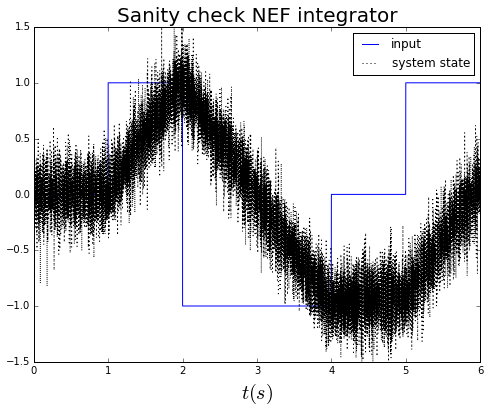

In [8]:
# run an integrator just to make sure the dynamics formulation works
A = 0
B = 1

t, in_dat, ens_dat = run_neural_dyn_sys(nneurons, dim, pstc, A, B, in_fun, T)
figure(figsize=(8,6))
plot(t, in_dat, label="input")
plot(t, ens_dat, 'k:', label="system state")
ylim(-1.5, 1.5)
xlabel(r'$t(s)$', fontsize=20)
legend(loc='best');
title('Sanity check NEF integrator', fontsize=20);